# VCM Shields PCA
---

In [ ]:
# Metadata
%load_ext watermark
%watermark -a "Lorenzo Piglia"
%watermark -u -n -t -z
%watermark -p numpy,matplotlib
%watermark

In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

## Read Images

In [9]:
dataset_path = r'C:\Users\HW5584\git\defect_detection_challenge\data_split\train\clean'
dataset_path_test = r'C:\Users\HW5584\git\defect_detection_challenge\data_split\test\clean'
dataset_dir  = os.listdir(dataset_path)

width = 2736
height = 1824

In [10]:
from glob import glob

train_image_names = glob(dataset_path + r"\*")
test_image_names = glob(dataset_path + r"\*")

### Faces

In [2]:
from sklearn import datasets
data = datasets.fetch_olivetti_faces()

training_tensor = data["data"]
height = 64
width = 64

In [11]:
from PIL import Image
training_tensor = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64)

for i in range(len(train_image_names)):
    img = Image.open(train_image_names[i]).convert("L")
    training_tensor[i,: ] = np.array(img, dtype='float64').flatten()

testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)

for i in range(len(test_image_names)):
    img = Image.open(test_image_names[i]).convert("L")
    testing_tensor[i,: ] = np.array(img, dtype='float64').flatten()

## Mean face

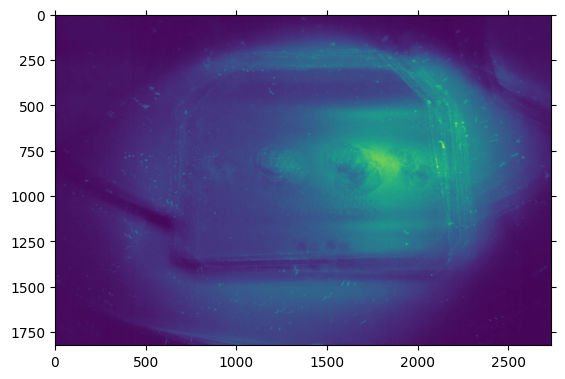

In [12]:
mean_face = np.mean(training_tensor, axis=0)

plt.imshow(mean_face.reshape(height, width))
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Normalised faces

In [13]:
normalised_training_tensor = np.ndarray(shape=(len(training_tensor), height*width))

for i in range(len(training_tensor)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i], mean_face)

In [ ]:
normalised_training_tensor.shape

In [ ]:
mean_face.min()

### Display normalised faces

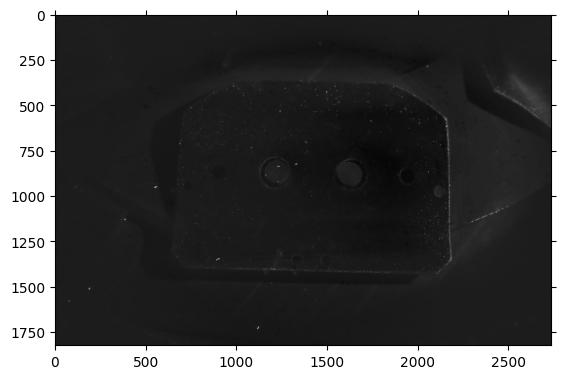

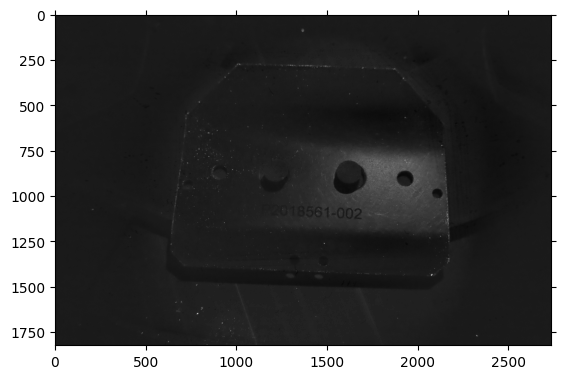

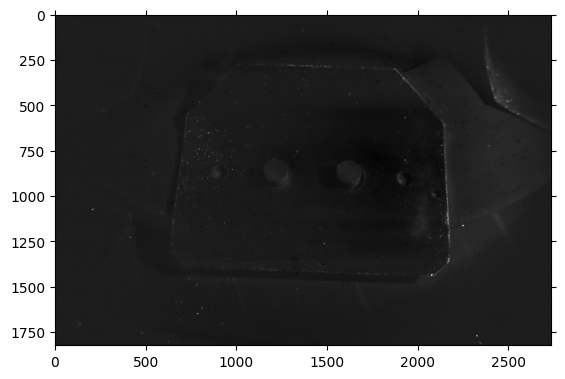

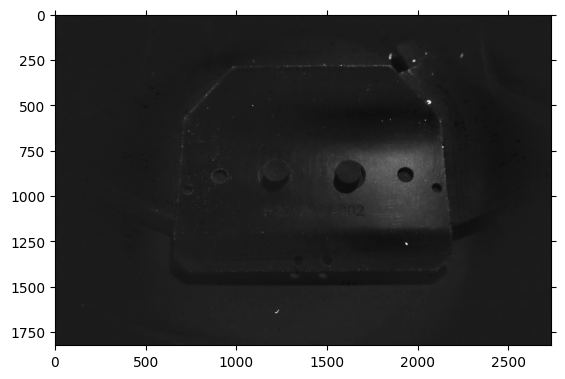

In [14]:
for i in range(4):
    img = normalised_training_tensor[i].reshape(height, width)

    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.show()

## Faster Method

In [34]:
normalised_training_tensor.shape

(400, 4096)

In [15]:
# Compute the smaller covariance matrix
C = np.dot(normalised_training_tensor, normalised_training_tensor.T)  # Shape (D, D)

# Eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(C)  # Eigenvectors of T^T T

eig_pairs = [(eigenvalues[index], eigenvectors[:, index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigenvalues = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigenvectors = [eig_pairs[index][1] for index in range(len(eigenvalues))]

# Compute eigenfaces
eigenfaces = np.dot(normalised_training_tensor.T, eigenvectors)  # Shape (D, k) where k is the number of components

# Normalize eigenfaces if needed
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)


In [24]:
eigenfaces.shape

(4990464, 46)

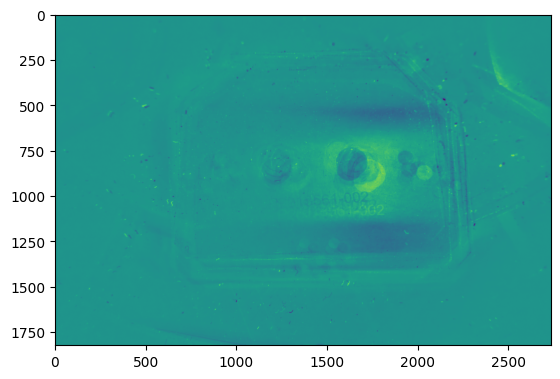

In [28]:
plt.imshow(eigenfaces.T[20].reshape(height, width))
plt.show()

## Standard (slower) method

In [195]:
mean_face = np.mean(training_tensor, axis=0)
X = training_tensor - mean_face

In [ ]:
X.shape

In [171]:
cov_matrix = np.cov(normalised_training_tensor, rowvar=False)
# cov_matrix = S = (1 / (400 - 1)) * (X @ X.T)
# cov_matrix = np.divide(cov_matrix, 8.0)
print('Covariance matrix of X: \n%s' %cov_matrix, "shape: ", cov_matrix.shape)

MemoryError: Unable to allocate 181. TiB for an array with shape (4990464, 4990464) and data type float64

In [ ]:
from scipy.special import softmax

eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
# eigenvectors_norm = softmax(eigenvectors)
print('Eigenvectors of Cov(X): \n%s' %eigenvectors)
print('\nEigenvalues of Cov(X): \n%s' %eigenvalues)

In [ ]:
# total variance
T = np.sum(eigenvalues)
print("T = {}".format(T))

In [ ]:
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [ ]:
eig_pairs = [(eigenvalues[index], eigenvectors[:, index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

In [ ]:
np.array(eigvectors_sort).shape

## Plots

In [21]:
def plot_eigen(k, eigenvectors):
    eigenvectors_red = eigenvectors[:, :k]
    sum = 0
    for i in range(k):
        sum += eigenvalues[i]
    print("Variance for k = {}: {}".format(k, sum))
    return eigenvectors_red
    # # PCA reconstruction
    # P = X @ eigenvectors_red # projection matrix
    # P = P @ eigenvectors_red.T
    # P += mean_face
    # return P

In [22]:
def display_eigenfaces(eigenfaces, i, h, w):
    plt.figure(figsize=(10, 5))
    # for i in range(eigenfaces.shape[1]):
    plt.imshow(eigenfaces[:, i].reshape(h, w), cmap='gray')
    plt.axis('off')
    plt.show()

In [23]:
k = 100
face = plot_eigen(k, eigenvectors)
display_eigenfaces(eigenvectors, 370, height, width)

TypeError: list indices must be integers or slices, not tuple

In [16]:
def project_onto_eigenfaces(image, mean_face, eigenfaces):
    # Flatten the image and center it
    image_flattened = image.flatten()
    centered_image = image_flattened - mean_face

    # Project onto the eigenfaces
    weights = np.dot(centered_image, eigenfaces)
    return weights

def reconstruct_face(weights, mean_face, eigenfaces):
    # Reconstruct the face from the weights
    reconstruction = mean_face + np.dot(weights, eigenfaces.T)
    return reconstruction

def display_image(image, title=''):
    plt.imshow(image.reshape(height, width), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [17]:
def reconstruct(k, image_to_reconstruct):
# Select an image to reconstruct (for example, the first image)

    display_image(image_to_reconstruct, title='Original Image')
    #
    # Project the image onto the eigenfaces
    weights = project_onto_eigenfaces(np.copy(image_to_reconstruct), mean_face, eigenfaces[:, :k])

    # Reconstruct the image
    reconstructed_image = reconstruct_face(weights, mean_face, eigenfaces[:, :k])

    # Display original and reconstructed images
    display_image(reconstructed_image, title=f'Reconstructed Image eith {k} eigenimages')

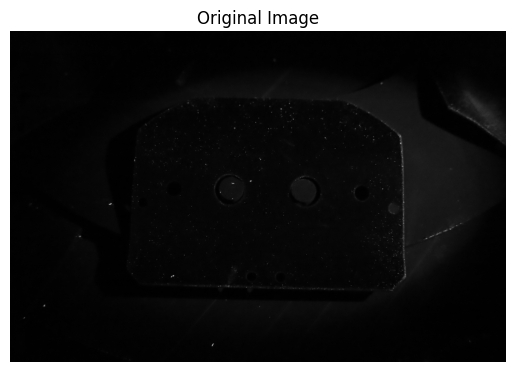

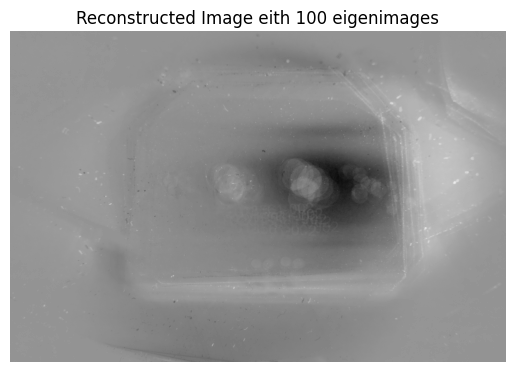

In [20]:
image_to_reconstruct = training_tensor[0]
reconstruct(100, image_to_reconstruct)

In [ ]:
eigenvectors.shape

In [ ]:
for k in range(15):
    img = plot_eigen(k, np.array(eigvectors_sort))
    plt.imshow(img.reshape(height, width))
    plt.show()

In [ ]:
eigenfaces = np.dot(normalised_training_tensor.transpose(), np.array(eigvectors_sort))

In [ ]:
eigenfaces_norm = eigenfaces/400

In [ ]:
for i in range(5):
    plt.imshow(eigenfaces_norm[:, i].reshape(height, width))
    plt.show()

In [ ]:
plt.imshow(eigenfaces_norm[:, 305].reshape(height, width))

In [ ]:
test_img = testing_tensor[10]
test_img = normalised_training_tensor[10]

In [ ]:
print(test_img.shape)
print(eigenfaces_norm.shape)

In [ ]:
weights = np.dot(test_img, eigenfaces_norm)

In [ ]:
reconstructFace = np.mean(training_tensor, axis=0)
components = np.dot(eigenfaces_norm.T, test_img)

In [ ]:
components = components/np.linalg.norm(components)

In [ ]:
reconstructFace.max()

In [ ]:
max(eigenfaces_norm.T[0])

In [ ]:
plt.imshow(reconstructFace.reshape(height, width))
plt.show()
for i in range(len(components)):
    print(components[i])
    reconstructFace += components[i] * eigenfaces.T[i]
    plt.imshow(reconstructFace.reshape(height, width))
    plt.show()
    

In [ ]:
test_img = testing_tensor[0]

## Find cumulative variance of each principle component

In [ ]:
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Show cumulative proportion of varaince with respect to components
print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1, len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

## Choose the necessary no.of principle components:

In [ ]:
eigvectors_sort = np.array(eigvectors_sort)
eigvectors_sort

In [ ]:
reduced_data = np.array(eigvectors_sort[:40]).transpose()

In [ ]:
reduced_data = eigvectors_sort.transpose()

Now we try to find the projected data. This will form the eigen space.

In [ ]:
proj_data = np.dot(training_tensor.transpose(), reduced_data)
proj_data = proj_data.transpose()

In [ ]:
proj_data

## Plot eigen faces

In [ ]:
plt.imshow(mean_face.reshape(height, width))
plt.show()
for i in range(proj_data.shape[0]):
    img = mean_face + proj_data[i]
    img = img.reshape(height, width)
    plt.imshow(img, cmap='jet')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off', top='off', right='off', left='off', which='both')
    plt.show()

In [ ]:
plt.imshow(testing_tensor[11].reshape(height, width))
plt.show()
plt.imshow(np.subtract(testing_tensor[11], mean_face).reshape(height, width))
plt.show()

In [ ]:
eigenimages = np.dot(eigenvectors, training_tensor)

In [ ]:
def reconstructFace(imVector, n):
  # Start with the mean / average face
  output = mean_face.reshape(height, width)
 
  for i in range(0, n):
    '''
    The weight is the dot product of the mean subtracted
    image vector with the EigenVector
    '''
    print(imVector.shape)
    print(eigenimages[i].shape)
    weight = np.dot(imVector, eigenimages[i])
    output = output + eigenimages[i].reshape(height, width) * weight
  return output

In [ ]:
eigenimages.shape

In [ ]:
def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return projected, components, mean, centered_data

In [ ]:
images=np.array([imread(image).a for image in train_image_names], dtype=np.float64)
n_samples, h, w = images.shape

In [ ]:
n_components = 50
X = images.reshape(n_samples, h*w)
P, C, M, Y= pca(X, n_pc=n_components)
eigenfaces = C.reshape((n_components, h, w))
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_portraits(eigenfaces, eigenface_titles, h, w, 4, 4) 

In [ ]:
for image in testing_tensor[:1]:
    test_normaling = np.subtract(image, mean_face)
    out = reconstructFace(test_normaling, 35)
    plt.imshow(out)

## Finding weights for each traning image

In [ ]:
w = np.array([np.dot(proj_data, i) for i in normalised_training_tensor])
w

## Now we recognise unknown face!

In [ ]:
unknown_face        = plt.imread('Dataset/subject12.normal.jpg')
unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()

plt.imshow(unknown_face, cmap='gray')
plt.title('Unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

### Normalise unknown face

In [ ]:
normalised_uface_vector = np.subtract(unknown_face_vector, mean_face)

plt.imshow(normalised_uface_vector.reshape(height, width), cmap='gray')
plt.title('Normalised unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

### Wieghts of uknown face

Projecting the normalized vector onto the eigenspace, to find out the weights:

In [ ]:
w_unknown = np.dot(proj_data, unknown_face_vector)
w_unknown

Finding the $min|W - W_{unknown}|$

In [ ]:
diff  = w - w_unknown
norms = np.linalg.norm(diff, axis=1)
print(norms)
min(norms)

## Reconizing all test images

In [ ]:
count        = 0
num_images   = 0
correct_pred = 0
def recogniser(img, train_image_names,proj_data,w):
    global count,highest_min,num_images,correct_pred
    unknown_face        = plt.imread('Dataset/'+img)
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(9,4,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
    t1 = 100111536
    #t1 = 200535910.268 # working with 6 faces
    #t0 = 86528212
    t0 = 88831687
    #t0 = 143559033 # working with 6 faces
    
    if norms[index] < t1:
        plt.subplot(9,4,1+count)
        if norms[index] < t0: # It's a face
            if img.split('.')[0] == train_image_names[index].split('.')[0]:
                plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='g')
                plt.imshow(imread('Dataset/'+train_image_names[index]), cmap='gray')
                
                correct_pred += 1
            else:
                plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='r')
                plt.imshow(imread('Dataset/'+train_image_names[index]), cmap='gray')
        else:
            if img.split('.')[0] not in [i.split('.')[0] for i in train_image_names] and img.split('.')[0] != 'apple':
                plt.title('Unknown face!', color='g')
                correct_pred += 1
            else:
                plt.title('Unknown face!', color='r')
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
        plt.subplots_adjust(right=1.2, top=2.5)
    else:     
        plt.subplot(9,4,1+count)
        if len(img.split('.')) == 3:
            plt.title('Not a face!', color='r')
        else:
            plt.title('Not a face!', color='g')
            correct_pred += 1
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1

fig = plt.figure(figsize=(15, 15))
for i in range(len(test_image_names)):
    recogniser(test_image_names[i], train_image_names,proj_data,w)

plt.show()

print('Correct predictions: {}/{} = {}%'.format(correct_pred, num_images, correct_pred/num_images*100.00))

## Normalised images

In [ ]:
count        = 0
def recogniser(img, train_image_names,proj_data,w):
    global count
    unknown_face        = plt.imread('Dataset/'+img)
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(9,4,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    plt.subplot(9,4,1+count)
    plt.imshow(normalised_uface_vector.reshape(height, width), cmap='gray')
    plt.title('Normalised Face')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.subplots_adjust(right=1.2, top=2.5)
    count+=1

fig = plt.figure(figsize=(15, 15))
for i in range(len(test_image_names)):
    recogniser(test_image_names[i], train_image_names,proj_data,w)

plt.show()